In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
X = np.load("/kaggle/input/vaporarray/test.out.npy")

data = X.astype(np.float64)*255
X = data.astype(np.uint8)

In [3]:
def plot_results(images, n_cols=None, unnorm=True):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image
        if unnorm:
          imageorg = (image +1) * 0.5
        plt.imshow(imageorg)
        plt.axis("off")

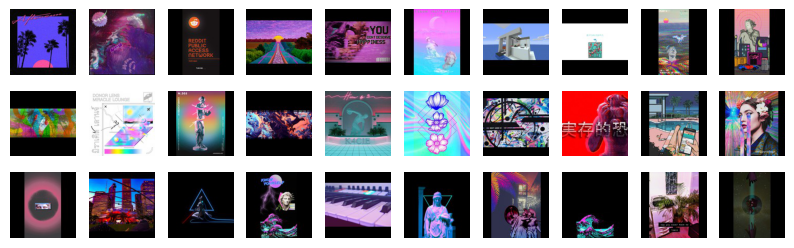

In [4]:
plot_results(X[0:30], 10, False)

In [5]:
BATCH_SIZE = 16

X = (X-127.5)/127.5
# X = X.reshape(-1,64,64,3)
X_train = tf.cast(X,tf.float32)


dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

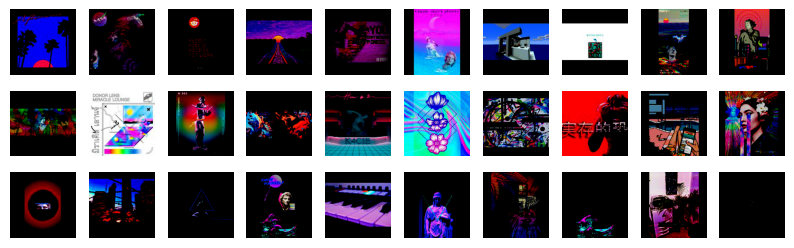

In [6]:
plot_results(X_train[0:30], 10, False)

In [50]:
noise_input = 50

generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Reshape([4,4, 128]),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(1024, kernel_size=3, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="SAME",
                                 activation='tanh'),
                       
])

shape of the generated batch: (16, 128, 128, 3)


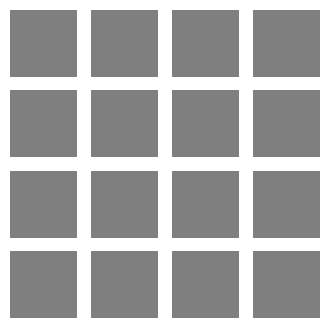

In [51]:
# generate a batch of noise input (batch size = 16)
#we got 16 noises to generate 16 images. 
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

In [52]:
# discriminator = keras.models.Sequential([
#     keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
#                         activation=keras.layers.LeakyReLU(0.2),
#                         input_shape=[128, 128, 3]),
#     keras.layers.Dropout(0.4),
#     keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
#                         activation=keras.layers.LeakyReLU(0.2)),
#     keras.layers.Dropout(0.4),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1, activation="sigmoid")
# ])

In [53]:
discriminator = keras.models.Sequential([
    
    keras.layers.Conv2D(512, kernel_size=2, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[128, 128, 3]),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(256, kernel_size=2, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, kernel_size=2, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, kernel_size=2, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(32, kernel_size=2, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [54]:
#The gan is formed by the generator and the discriminator
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 128, 128, 3)       7525251   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 1227745   
                                                                 
Total params: 8,752,996
Trainable params: 8,748,836
Non-trainable params: 4,160
_________________________________________________________________


In [55]:
 #discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gan = keras.optimizers.Adam(learning_rate=0.0006, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gan)

In [56]:
#functions to smooth the labels. Positive, and negative.
def smooth_positive(y):
  #range values 0.8 - 1.2
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  #range values 0 - 0.3
  return y + np.random.random(y.shape) * 0.3

In [61]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
            discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
            discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
            #discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_ones = smooth_positive(np.ones((batch_size, 1)))
            generator_labels = tf.convert_to_tensor(generator_ones)
            #generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images[0:30], 10)    
        tf.keras.preprocessing.image.save_img('generated_image_{}.png'.format(epoch),fake_images[0])
        plt.show()  

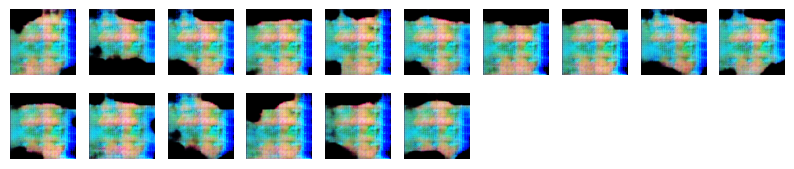

In [62]:
train_gan(gan, dataset, noise_input, 60)

In [ ]:
test_noise = tf.random.normal([1, noise_input])
test_image = generator(test_noise)
plot_results(test_image, n_cols=4)

In [38]:
tf.keras.preprocessing.image.save_img('generated)image.png',test_image[0])